# Import libraries

In [18]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

# Create corpus

In [19]:
root_dir = "../data_raw/topics"
corpus = []
corpus_size = 10000
done = False

print("Loading poems in corpus...\n")
for dirname, _, filenames in os.walk(root_dir):
    if done: break
    print(f"Loading {dirname}")
    for filename in filenames:
        if done: break
        with open(os.path.join(dirname, filename), "r") as file:
            txt = file.read()
            for line in txt.split("\n"):
                if done: break
                corpus.append(line)
                if len(corpus) == corpus_size:
                    done = True

Loading poems in corpus...

Loading /home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/topics
Loading /home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/topics/red
Loading /home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/topics/sorrow
Loading /home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/topics/loss
Loading /home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/topics/dance


In [20]:
len(corpus)

10000

In [21]:
corpus[:10]

['A single red rose',
 'lays on a grave,',
 'for someone buried there.',
 'It spoke of love,',
 'that would always remain strong,',
 'even though the loved one was now gone.',
 'It spoke of something lasting,',
 'beyond our living days.',
 'Tells the story about love',
 'that never ever fades away.']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [22]:
import string

def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

corpus = [ remove_punc(s.lower().strip()) for s in corpus ]

In [23]:
corpus[:10]

['a single red rose',
 'lays on a grave',
 'for someone buried there',
 'it spoke of love',
 'that would always remain strong',
 'even though the loved one was now gone',
 'it spoke of something lasting',
 'beyond our living days',
 'tells the story about love',
 'that never ever fades away']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [25]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9161


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [26]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 52665
Maximum n-gram length: 139


In [27]:
for n_gram in n_grams[:10]:
    print(n_gram)

[5, 583]
[5, 583, 29]
[5, 583, 29, 97]
[1810, 18]
[1810, 18, 5]
[1810, 18, 5, 541]
[13, 295]
[13, 295, 1041]
[13, 295, 1041, 48]
[14, 915]


## Pad n-grams

In [28]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(52665, 100)

In [29]:
for seq in padded_n_grams[:3]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   5 583]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   5 583  29]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

## Split n-grams into X and y

In [30]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (52665, 99)
y: (52665,)


In [31]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (52665, 9161)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [32]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 53s 126ms/step - accuracy: 0.0443 - loss: 7.5480
Epoch 2/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 53s 130ms/step - accuracy: 0.0644 - loss: 6.7502
Epoch 3/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.0766 - loss: 6.5129
Epoch 4/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 53s 128ms/step - accuracy: 0.0924 - loss: 6.2534
Epoch 5/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 52s 127ms/step - accuracy: 0.1009 - loss: 6.0528
Epoch 6/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - accuracy: 0.1112 - loss: 5.8254
Epoch 7/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - accuracy: 0.1209 - loss: 5.6633
Epoch 8/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 51s 125ms/step - accuracy: 0.1259 - loss: 5.5181
Epoch 9/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 113ms/step - accuracy: 0.1367 - loss: 5.3437
Epoch 10/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.1464 - loss: 5.1884
Epoch 11/125
412/412 ━━━━━━━━━━━━━━━━━━━━ 47s 115ms/step - accuracy: 0.1569 - loss: 5.0196
Epoch 12

# Plot learning curves

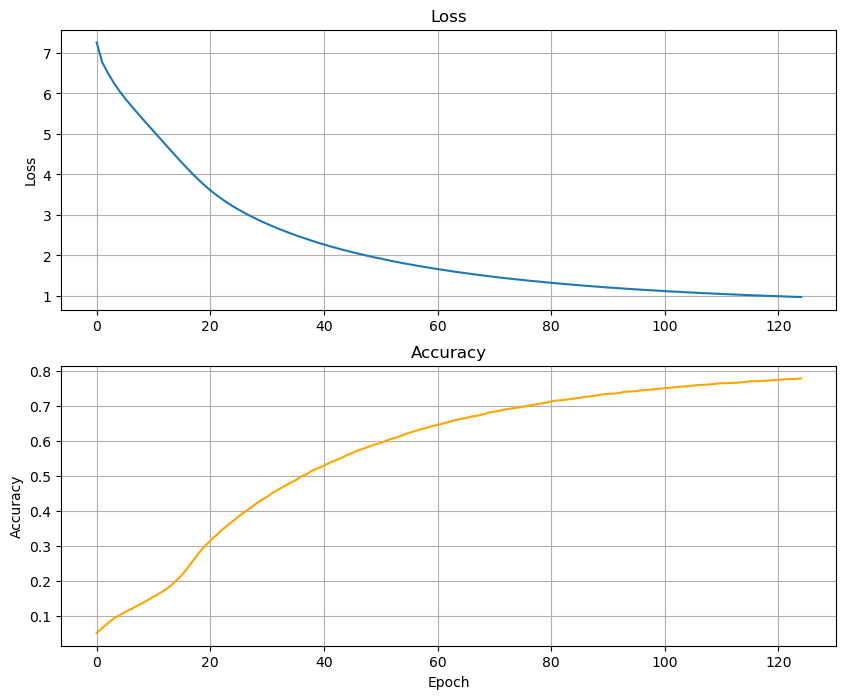

In [34]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [35]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [36]:
generate("Long live the king", 200)

Long live the king have lost a spade for in this dream of new life to dream the more i cry the more i cry every night of pain and it wasnt your fault that you are merely 7 else but the harder i try it was his majestys love and his love – what seemed the pain or getting hurt again but the pain always hoping to know you must take all for peace with him the help this poem was aimed at countering a criminalisation policy by the british government his name became a household word in ireland and his sacrifice as did that of those who followed him overturned british propaganda on ireland and had a real effect in advancing the cause of irish freedom of brain hidden back too misery for misery for misery again the cause of irish freedom of brain or this would cannot getting hurt that was so silent life never to the way this morning this time of this short and short will face to abandon his fast which was aimed at countering a criminalisation policy by the british government his name became a hou

That's some interesting poetry!